In [1]:
import numpy as np
import scipy as sp
from scipy import signal
from math import isclose
from itertools import combinations
import warnings

import cv2 as cv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
import matplotlib.mlab as mlab

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

np.random.seed(0)

# Data Preprocessing

In [2]:
in_file = "../data/output_qep/ind_joins.csv"

#2^15 = 32k
COMBINATIONS = 2**15
WORKLOAD_SIZE = 1
batch = 2**5



data = []

with open(in_file,'r') as f:
    lines = f.readlines()
    
    n_operators = int(lines[0])
    n_tables = int(lines[1])
    lines = lines[2:]

    data = np.array([line.split(',') for line in lines], dtype=float)
    
data_len = len(data[0])
print(f"length of vector {len(data[0])}")
print(f"number of vectors {len(data)}")

number_of_samples = 5000

queries = []
for i in range(number_of_samples):
    # get random indices to generate workloads
    workload = np.array([np.random.randint(0, len(data)) for i in range(WORKLOAD_SIZE)])
    # get the data from those indices
    workload = np.take(data, workload, axis=0)
    # average the workload
    workload = np.mean(workload, axis=0)
    # append those queries
    queries.append(workload)

data = np.array(queries)

print("length of augmented data: {}".format(len(data)))
print("shape of augmented data: {}".format(data.shape))

"""
# normalize the data
data_max = np.max(data, axis = 0)
data_min = np.min(data, axis = 0)
data = np.divide((data - data_min), (data_max - data_min), where=(data_max - data_min)!=0)
"""

# take the log the cost to squash it
data[:,n_operators + n_tables:] = np.log10(data[:,n_operators + n_tables:], where=(data[:,n_operators + n_tables:] > 1)) 
data[:,n_operators + n_tables:] = np.log10(data[:,n_operators + n_tables:], where=(data[:,n_operators + n_tables:] > 1))

# convert the data into the expected tensor form
data = [torch.Tensor(d) for d in data]
np.random.shuffle(data)

# create our train test split
pct = 0.9
train = data[:int(len(data)* pct)]
test = data[int(len(data)*pct):]




length of vector 80
number of vectors 460
length of augmented data: 5000
shape of augmented data: (5000, 80)


In [3]:
data[0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.2100, 0.8238, 0.7815, 0.1885, 0.8236, 0.7030, 0.1204])

# Variational Autoencoder Neural Architecture

In [4]:
class MyVAE(nn.Module):
    def __init__(self, latent_size = 10, number_of_layers = 10):
        super().__init__()
        self.latent_size = latent_size
        self.layer_sizes = [self.latent_size + (data_len - self.latent_size) // (number_of_layers - 1) * 
                                    i for i in range(number_of_layers - 1)] + [data_len]
        
        self.layer_sizes = self.layer_sizes[::-1]
        print(self.layer_sizes)
        
        self.encoder = []
        self.decoder = []
        
        # Encoder
        for i in range(len(self.layer_sizes) - 1):
            self.encoder.append(
                nn.Sequential(
                    #nn.BatchNorm1d(self.layer_sizes[i]),
                    nn.Linear(self.layer_sizes[i], self.layer_sizes[i + 1]),
                    nn.BatchNorm1d(self.layer_sizes[i + 1]),
                    nn.LeakyReLU()))
        self.encoder = nn.Sequential(*self.encoder)

        # Decoder
        for i in range(len(self.layer_sizes) - 1):
            self.decoder.append(
                nn.Sequential(
                    #nn.BatchNorm1d(self.layer_sizes[~i]),
                    nn.Linear(self.layer_sizes[~i], self.layer_sizes[~i - 1]),
                    nn.BatchNorm1d(self.layer_sizes[~i - 1]),                    
                    nn.LeakyReLU()))
        self.decoder = nn.Sequential(*self.decoder)
        
        self.mu = nn.Linear(self.layer_sizes[-1], self.latent_size)
        self.sigma = nn.Linear(self.layer_sizes[-1], self.latent_size)
        self.fc = nn.Sequential(
                    nn.Linear(data_len, data_len),
                    nn.ReLU(),
                    nn.Tanh()
                )
    
    def __print__(self):
        return self.encoder + self.decoder
    
    def encode(self, x):
        #print('encode x', x)
        x = self.encoder(x)
        #print('encode ex', x)
        x = torch.flatten(x, start_dim = 1)
        #print('encode fx', x)
        return [self.mu(x), self.sigma(x)]
    
    def decode(self, z):
        #print('decode z: ', z.shape)
        #print('decode liz: ', z.shape)
        #print('decode rsz: ', z.view(z.shape[0],z.shape[1],1).shape)
        z = self.decoder(z)
        #print('decode dz:  ', z.shape)
        z = self.fc(z.squeeze(-1))
        #print('decode fz:  ', z.shape)
        return z
    
    def reparameterize(self, mu, sigma):
        std = torch.exp(0.5 * sigma)
        eps = torch.randn_like(std)
        return mu + sigma * eps
        
    
    def loss(self, reconstructed_x, x, mu, log_var):
        n = n_tables + n_operators

        # BCE for the tables?
        #bce_l1 = binarize(reconstructed_x[:n])
        #bce_l2 = binarize(x[:n])
        #reconstr_loss = F.binary_cross_entropy(torch.sigmoid(torch.tensor(bce_l1)), bce_l2)

        # MSE for the costs?
        #reconstr_loss += F.mse_loss(reconstructed_x[-7:], x[-7:])
        
        reconstr_loss = F.mse_loss(reconstructed_x, x)
        kl_divergence = torch.mean(0.5 * torch.sum(log_var.exp() + mu ** 2 - 1 - log_var, dim = 1), dim = 0)
        #print(f"kl_divergence {kl_divergence}")
        #print(f"reconstr_loss {reconstr_loss}")

        return kl_divergence*20 + reconstr_loss
    
    def sample(self, batch_size, eps = None):
        z = torch.randn(batch_size, self.latent_size)
        return self.decode(z)
        
    def forward(self, x):
        #print('forward x: ', x.shape)
        mu, sigma = self.encode(x)
        z = self.reparameterize(mu, sigma)
        #print('forward rz: ', z.shape)
        z = self.decode(z)
        #print('forward dz: ', z.shape)
        
        return [z, x, mu, sigma]
    
    def save(self, path):
        torch.save(self.state_dict(), path)
    
    
vae = MyVAE()
vae.train()
#net.apply(initialize_weights)


[80, 66, 59, 52, 45, 38, 31, 24, 17, 10]


MyVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=80, out_features=66, bias=True)
      (1): BatchNorm1d(66, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=66, out_features=59, bias=True)
      (1): BatchNorm1d(59, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=59, out_features=52, bias=True)
      (1): BatchNorm1d(52, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Linear(in_features=52, out_features=45, bias=True)
      (1): BatchNorm1d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequential(
      (0): Linear(in_features=45, out_features=38, bias=Tru

# VAE Training

In [5]:
losses = []
running_loss = 0
number_of_epochs = 40
display_frq = 20

number_of_layers = 5
latent_size = 5

vae = MyVAE(latent_size, number_of_layers)
vae.train()

optimizer = optim.Adam(vae.parameters(), lr=1e-3)

train_loader = torch.utils.data.DataLoader(train, batch_size = batch, shuffle = True, num_workers = 4)

for epoch in range(number_of_epochs):
    for i, d in enumerate(train_loader, 0):
        if len(d) < batch:
            break
            
        optimizer.zero_grad()

        reconstr_x, x, mu, sigma = vae(d)

        #print('reconstr_x: ', reconstr_x.shape)
        #print('x:        : ', x.shape)

        loss = vae.loss(reconstr_x.unsqueeze(-1), x.unsqueeze(-1), mu, sigma)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # append the end of epoch numbers for plotting
        if i % len(train_loader) == 0:
            losses.append([len(losses), running_loss])
        # display te loss every 'display_frq' inputs
        if i % display_frq == display_frq - 1:
            print('[epoch %d, i %4d] loss: %.3f' % (epoch + 1, i+ 1, running_loss / 100))
            running_loss = 0.

[80, 59, 41, 23, 5]
[epoch 1, i   20] loss: 2.658
[epoch 1, i   40] loss: 1.704
[epoch 1, i   60] loss: 1.235
[epoch 1, i   80] loss: 0.977
[epoch 1, i  100] loss: 0.774
[epoch 1, i  120] loss: 0.626
[epoch 1, i  140] loss: 0.494
[epoch 2, i   20] loss: 0.399
[epoch 2, i   40] loss: 0.319
[epoch 2, i   60] loss: 0.258
[epoch 2, i   80] loss: 0.215
[epoch 2, i  100] loss: 0.181
[epoch 2, i  120] loss: 0.169
[epoch 2, i  140] loss: 0.138
[epoch 3, i   20] loss: 0.128
[epoch 3, i   40] loss: 0.115
[epoch 3, i   60] loss: 0.100
[epoch 3, i   80] loss: 0.087
[epoch 3, i  100] loss: 0.086
[epoch 3, i  120] loss: 0.069
[epoch 3, i  140] loss: 0.082
[epoch 4, i   20] loss: 0.065
[epoch 4, i   40] loss: 0.059
[epoch 4, i   60] loss: 0.055
[epoch 4, i   80] loss: 0.057
[epoch 4, i  100] loss: 0.048
[epoch 4, i  120] loss: 0.046
[epoch 4, i  140] loss: 0.045
[epoch 5, i   20] loss: 0.040
[epoch 5, i   40] loss: 0.036
[epoch 5, i   60] loss: 0.040
[epoch 5, i   80] loss: 0.037
[epoch 5, i  100] lo

[epoch 39, i   20] loss: 0.008
[epoch 39, i   40] loss: 0.009
[epoch 39, i   60] loss: 0.009
[epoch 39, i   80] loss: 0.008
[epoch 39, i  100] loss: 0.010
[epoch 39, i  120] loss: 0.010
[epoch 39, i  140] loss: 0.009
[epoch 40, i   20] loss: 0.010
[epoch 40, i   40] loss: 0.009
[epoch 40, i   60] loss: 0.010
[epoch 40, i   80] loss: 0.007
[epoch 40, i  100] loss: 0.008
[epoch 40, i  120] loss: 0.009
[epoch 40, i  140] loss: 0.009


[[1.94170494e+01]
 [2.12833166e+00]
 [9.00242805e-01]
 [2.54265070e-01]
 [1.64694667e-01]
 [1.19279183e-01]
 [1.60458207e-01]
 [1.17345951e-01]
 [8.23516622e-02]
 [6.98543489e-02]
 [8.45493674e-02]
 [8.71892944e-02]
 [6.40542507e-02]
 [6.37051165e-02]
 [4.66093086e-02]
 [3.94668467e-02]
 [4.08313982e-02]
 [4.62522618e-02]
 [5.66550344e-02]
 [7.97048137e-02]
 [4.03653048e-02]
 [5.77956587e-02]
 [3.56908180e-02]
 [3.51949558e-02]
 [4.72944379e-02]
 [3.17276530e-02]
 [6.34174943e-02]
 [4.46566641e-02]
 [3.96997891e-02]
 [2.91195437e-02]
 [4.14881185e-02]
 [2.01595910e-02]
 [5.38098030e-02]
 [7.73587823e-02]
 [4.74785045e-02]
 [2.33424939e-02]
 [3.54639255e-02]
 [3.77456509e-02]
 [2.90746503e-02]
 [1.77396685e-02]]


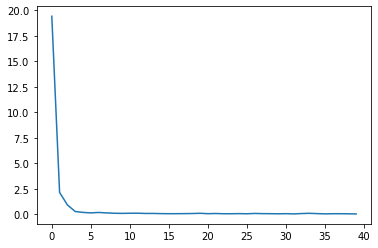

In [6]:
print(np.array(losses)[:,1:])
plt.plot(np.array(losses)[:,1:])
#vae.save('20d_10l_vae')

In [7]:
#vae.load_state_dict(torch.load('1d_vae'))
#vae.load_state_dict(torch.load('10d_20l_vae'))
test_loader = torch.utils.data.DataLoader(test, batch_size = batch, shuffle = True, num_workers = 4)
data_iter = iter(test_loader)

In [8]:

data = next(data_iter)

with torch.no_grad():
    reconstr_x, x, mu, sigma = vae(data)
    
i = -1

torch.Size([80])
torch.Size([80])


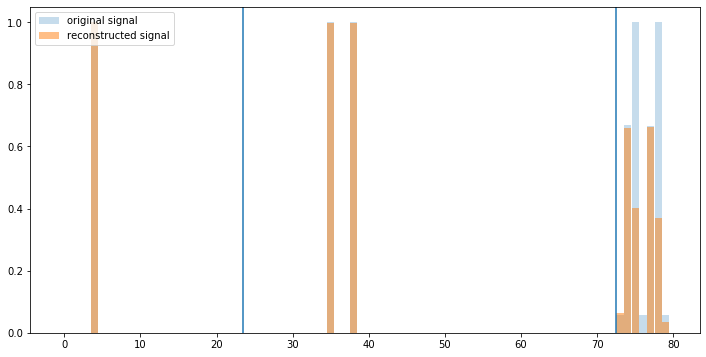

In [9]:
i += 1

ox = x[i].squeeze(-1)
rx = reconstr_x[i]
plt.figure(figsize=(12,6))
# Plot the data
xlin = np.arange(data_len)

#plt.plot(xlin,rx,'.-r', label='reconstructed data')
#plt.plot(xlin,ox,'.-', label='original data')

plt.bar(xlin,ox, width=0.95, label='original data', alpha=0.25)
plt.bar(xlin,rx, width=0.95, label='reconstructed data', alpha=0.5)

plt.legend(['original signal', 'reconstructed signal']);
plt.axvline(x=float(n_operators) - 0.5)
plt.axvline(x=float(n_tables + n_operators) - 0.5)

print (ox.shape)
print (rx.shape)

# Latent Perturbation

In [10]:
if 0:
    INDEX = 0

    test_loader = torch.utils.data.DataLoader(test, batch_size = batch, shuffle = True, num_workers = 4)
    data_iter = iter(test_loader)
    # get one data pt
    data = next(data_iter)

    # get the lerp vals
    lerp_offset = 1
    lerp_range = 0.0
    interp = [b * (1.0 / batch) * lerp_range + lerp_offset for b in range(batch)]

    # get our latent space representations from the encoder
    with torch.no_grad():
        # encode
        print('data shape:',data.shape)
        mu, sigma = vae.encode(data)
        # decode; lock a variable, permute, decode
        z = vae.reparameterize(mu, sigma)

    print(z.shape)
    # get the first result; permute across the latent space
    for i in range(batch):
        z[i][INDEX] = interp[i]


    # get ours reconstructions from the permuted latent spaces
    with torch.no_grad():
        results = vae.decode(z)

    x = np.linspace(0,data_len,data_len)
    y = np.linspace(0,batch,batch)

    xc, yc = np.meshgrid(x, y)
    res_surf = np.array(results)

    fig = plt.figure(figsize=(20,15))
    ax = fig.gca(projection='3d')
    #YlOrRd
    surf = ax.plot_surface(xc, yc, res_surf, cmap="coolwarm",
                           linewidth=0, antialiased=False)

In [11]:
if 0:
    fig=plt.figure()
    plt.ylim(top=15)

    n=256 #Number of frames
    x=range(56)
    bars = plt.bar(x,results[0])

    def animate(i):
        for j, b in enumerate(bars):
            b.set_height(results[i][j])

    anim=animation.FuncAnimation(fig,animate,repeat=False,blit=False,frames=n,
                                 interval=100)

    anim.save('latent_perturbation.mp4',writer=animation.FFMpegWriter(fps=30))
    plt.show()

# Similarity Measures

In [12]:
def cosine_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
pt = -1

In [13]:
pt += 1

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    most_similar = 0
    least_similar = None

    # select a data point
    d1 = data[pt]
    d2 = None
    d3 = None

    vae.eval()

    # get the closest and farthest vectors via cosine similarity
    for i in range(1, len(data)):
        similarity = cosine_sim(d1, data[i])
        if similarity > most_similar and not np.isclose(1, similarity):
            most_similar = similarity
            d2 = data[i]
        if least_similar is None or similarity < least_similar:
            least_similar = similarity
            d3 = data[i]

    print("pre-embedding")
    print("=============")
    print("(close) similarity: %.4f" % (cosine_sim(d1, d2)))
    print("(far)   similarity: %.4f" % (cosine_sim(d1, d3)))

    # using the trained network, embed the points and
    with torch.no_grad():
        # get the embedded version of d1
        d1 = torch.tensor(d1.reshape(1, data_len))
        r1, _, _, _ = vae(d1)

        d2 = torch.tensor(d2.reshape(1, data_len))
        r2, _, _, _ = vae(d2)

        d3 = torch.tensor(d3.reshape(1, data_len))
        r3, _, _, _ = vae(d3)

    d1r2 = cosine_sim(d1[0], r2[0])
    d1r3 = cosine_sim(d1[0], r3[0])
    print("\npost-embedding")
    print("=============")
    print("(close) similarity: %.4f" % d1r2)
    print("(far)   similarity: %.4f" % d1r3)

pre-embedding
(close) similarity: 0.9175
(far)   similarity: 0.3044

post-embedding
(close) similarity: 0.9080
(far)   similarity: 0.4949
